# Acknowledgements

Notebook developed by Andrew Ferguson for the UChicago course MENG15100: Machine Learning and Artificial Intelligence for Molecular Discovery and Engineering.

Components of these notebooks and code were borrowed and adapted from the [Data@PSL](https://github.com/data-psl) tutorials originally written by Pierre Ablin, Mathieu Blondel and Arthur Mensch under the [MIT License](https://github.com/data-psl/lectures2025/blob/main/LICENSE). Some materials therein were adapted from [sklearn tutorials](https://github.com/jakevdp/sklearn_tutorial/tree/master) developed by Jake Vanderplas under the [BSD-3 License](https://github.com/jakevdp/sklearn_tutorial/blob/master/LICENSE).

# Dimensionality Reduction using Principal Components Analysis (PCA)

Here we'll explore **Principal Components Analysis** as a simple and powerful linear dimensionality reduction technique.

## Library Import

First let's import the libraries we will need for this analysis.

In [3]:
from __future__ import print_function, division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA

## Data Exploration

Now let's generate a 2D data set that is amenable to easy visualization and which we will use to motivate, understand, and conduct PCA.

In [59]:
np.random.seed(42)

num_points = 500
mean = [0, 0]
cov = [[10, 0], [0, 0.3]]  # Stretch along x-axis (ellipse)
X = np.random.multivariate_normal(mean, cov, size=num_points)

theta = np.radians(30)  # Rotate the dataset to make PCA more illustrative
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta),  np.cos(theta)]])
X = X @ rotation_matrix.T

print(X.shape)

(500, 2)


Now let's plot the data.

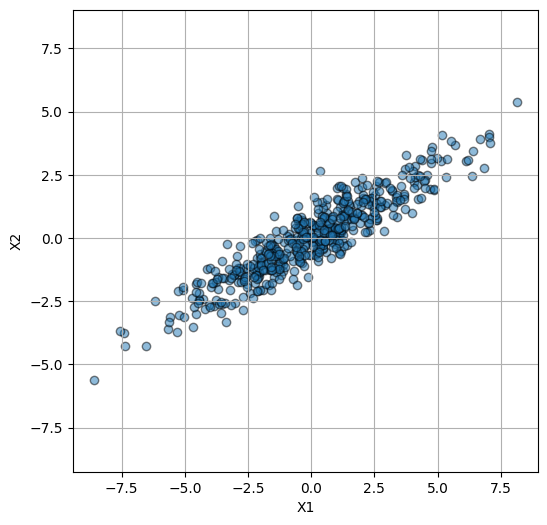

In [60]:
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5, edgecolor='k')
plt.axis('equal')
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)
plt.show()

What do you notice about the data?
> * Is the data uniformly distributed, or does it have a particular shape?
* Is one direction in the data more important than another?
* Is the X1 component of the data more important than the X2 component?
* Is there another component that is a mix of X1 and X2 that is the most important?
* What do we mean by "important"?

## Variance

Let's compute the **variance** of the data set along the X1 and X2 directions. The variance is a mathematical concept that reports how spread out the data is along a particular direction.

Given some data point $\{x_i\}_{i=1}^N$, we can compute the **mean** as:

$\mu = \frac{1}{N}\sum_{i=1}^N x_i$

and the **variance** as:

$\sigma^2 = \frac{1}{N}\sum_{i=1}^N (x_i - \mu)^2$

The **standard deviation** $\sigma$ is just the square root of the variance.

In [61]:
print('Mean(X1) = %.3f' % (np.mean(X[:, 0])))
print('Mean(X2) = %.3f' % (np.mean(X[:, 1])))

Mean(X1) = 0.000
Mean(X2) = 0.022


In [62]:
cov = np.cov(X.T)
print('Var(X1) = %.3f' % (cov[0, 0]))
print('Var(X2) = %.3f' % (cov[1, 1]))

Var(X1) = 7.125
Var(X2) = 2.521


Recall that we are in the **unsupervised learning** regime, so our data $X$ do not have any accompanying labels $y$. In the unsupervised regime, we do not have any concept of a predictive accuracy by which to define a loss function and fit a model.

> *It is the primary goal of PCA to find a lower-dimensional representation of the data that preserves the maximum amount of variance in the data.*

The underlying assumption of this objective is that more information is carried in elongated directions as opposed to squashed directions.

The "natural" way to represent our data is by the $X1$ and $X2$ features.

Let's take a quick look at the first few rows of the 2D $X = \{X1,X2\}$ data.

In [63]:
print("           X1","         X2")
print(X[:10])

           X1          X2
[[ 1.39817297  0.71978952]
 [ 1.35666921  1.74652199]
 [-0.57713438 -0.4812899 ]
 [ 4.11468175  2.86098096]
 [-1.43429474 -0.48494536]
 [-1.14157627 -0.95364273]
 [ 1.18661435 -0.52497256]
 [-4.56989325 -2.99405096]
 [-2.85981243 -1.45236601]
 [-2.09995105 -2.10562659]]


Our data is 2D, meaning that each instance is represeted by two features $X1$ and $X2$.

* If we had to choose to represent the data in 1D using only a single feature, would you pick -- $X1$ or $X2$?
* Why?

This is the essence of dimensionality reduction\!

## Rotation

Can we do better than just picking $X1$ or $X2$ for our compressed 1D representation of the data?

**Yes!** In our data exploration above, we noted that there was a mixed direction containing a lot of $X1$ mixed in with a bit of $X2$ that defines a sloped or diagonal direction that looks like it may contain even more variance than $X1$ or $X2$.

Let's look into this further by trying to find some new directions that carry more variance. Graphically, we can do so by effectively **"tilting our head"** or **rotating the coordinate frame** to represent our data in a new rotated set of axes. We hypothesize that by passing one of our coordinate axes along the elongated aspect of the data might allow us to achieve a 1D representation preserving much more of the variance.

>Mathematically, we would like to **maximize the variance carried in each axis of the rotated frame**. This defines our PCA objective function that we seek to maximize: \\
> $L = \sum_i Var(PC_i)$, \\
> where $PC_i$ are the **principal components** defining the directions of our rotated axes.

Let's play with the Python GUI below to rotate the coordinate frame and try to maximize the variance carried along the rotated axes.

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
import matplotlib

# Ensure clean plots in Colab
matplotlib.rcParams['figure.figsize'] = [6, 6]

# Interactive plot function
def plot_rotated_axes(theta_deg):
    theta = np.radians(theta_deg)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta),  np.cos(theta)]])

    # Unit vectors
    unit_vec1 = rotation_matrix[:, 0]
    unit_vec2 = rotation_matrix[:, 1]

    # Project data onto rotated unit vectors
    proj1 = X @ unit_vec1
    proj2 = X @ unit_vec2

    # Variances along rotated axes
    var1 = np.var(proj1)
    var2 = np.var(proj2)
    total_var = var1 + var2

    # Plot
    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], alpha=0.3, edgecolor='k', label='Data')

    origin = np.mean(X, axis=0)
    scale = 5  # for visual length of arrows

    # Draw unit vectors
    arrow1 = unit_vec1 * scale
    arrow2 = unit_vec2 * scale
    plt.quiver(*origin, *arrow1, color='red', angles='xy', scale_units='xy', scale=1, label='PC1')
    plt.quiver(*origin, *arrow2, color='blue', angles='xy', scale_units='xy', scale=1, label='PC2')

    # Label variances next to each vector tip
    tip1 = origin + arrow1
    tip2 = origin + arrow2
    plt.text(tip1[0], tip1[1], f"Var(PC1) = {var1:.2f}", color='red', fontsize=10, ha='left', va='bottom')
    plt.text(tip2[0], tip2[1], f"Var(PC2) = {var2:.2f}", color='blue', fontsize=10, ha='left', va='bottom')

    # Total variance in bottom-right corner
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.text(xmax - 2, ymin + 1, f"Total Variance: {total_var:.2f}",
             ha='right', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

    plt.title(f"Rotated Axes at θ = {theta_deg:.1f}°")
    plt.axis('equal')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.grid(True)
    plt.legend()
    plt.show()

# Slider widget
interact(plot_rotated_axes, theta_deg=FloatSlider(value=0, min=0, max=360, step=5, description='θ (degrees)'))

interactive(children=(FloatSlider(value=0.0, description='θ (degrees)', max=360.0, step=5.0), Output()), _dom_…

<function __main__.plot_rotated_axes(theta_deg)>

Graphically, we can see that $\theta$ is controlling the mixing between $X1$ and $X2$:

$PC1 = \cos(\theta) X1 + \sin(\theta) X2$

And since $PC2$ has to be **orthogonal** (i.e., at right angles to) $PC1$:

$PC2 = -\sin(\theta) X1 + \cos(\theta) X2$

What is the optimal rotation angle that places the most variance in PC1?

Store this value below.

In [65]:
theta = 0.0

OK, now instead of keeping the *data fixed* and looking at our *rotated axes* move, let's flip the script and instead *keep the axes fixed* and *rotate the data*.

We will also report out next to the plot the coordinates of the data in the original coordinate frame ($X1,X2$) and in the rotated frame ($PC1,PC2$).

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
import matplotlib
import pandas as pd
from IPython.display import display
import ipywidgets as widgets

# Ensure clean plots in Colab
matplotlib.rcParams['figure.figsize'] = [6, 6]

# Interactive plot function
def plot_rotated_axes(theta_deg):
    theta = np.radians(theta_deg)

    # Rotation matrix to rotate the data visually
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                [np.sin(theta),  np.cos(theta)]])

    # Rotate data (visual rotation)
    X_rotated = X @ rotation_matrix  # Not .T — we want to rotate the data itself

    # Variance along PC1 and PC2 (now x and y in rotated frame)
    var_pc1 = np.var(X_rotated[:, 0])
    var_pc2 = np.var(X_rotated[:, 1])

    # ⬅️ Set up side-by-side output with two widgets
    output_plot = widgets.Output()
    output_table = widgets.Output()

    with output_plot:
        # Plot rotated data
        plt.figure()
        plt.scatter(X_rotated[:, 0], X_rotated[:, 1], alpha=0.3, edgecolor='k', label='Rotated Data')

        # Variance info in bottom-right corner
        xmin, xmax = plt.xlim()
        ymin, ymax = plt.ylim()
        info_text = f"Var(PC1) = {var_pc1:.2f}\nVar(PC2) = {var_pc2:.2f}"
        plt.text(xmax - 2, ymin + 1, info_text,
                 ha='right', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

        plt.title(f"Rotated Data at θ = {theta_deg:.1f}°")
        plt.axis('equal')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.grid(True)
        plt.legend()
        plt.show()

    with output_table:
        # Create DataFrame of first 10 points
        df = pd.DataFrame({
            'X1': X[:15, 0],
            'X2': X[:15, 1],
            'PC1': X_rotated[:15, 0],
            'PC2': X_rotated[:15, 1]
        })
        display(df.round(3))  # Round for readability

    # Display both
    display(widgets.HBox([output_plot, output_table]))

# Slider widget
interact(plot_rotated_axes, theta_deg=FloatSlider(value=0, min=0, max=360, step=5, description='θ (degrees)'))


interactive(children=(FloatSlider(value=0.0, description='θ (degrees)', max=360.0, step=5.0), Output()), _dom_…

<function __main__.plot_rotated_axes(theta_deg)>

Dial in your optimal $\theta$ to the plot above to maximize the variance contained in PC1.

Now, within the rotated coordinate frame we still have 2D data represented by $PC1,PC2$ instead of $X1,X2$.

* If we had to choose to represent the data in 1D using only a single feature, would you pick -- $PC1$ or $PC2$?
* How much variance is preserved in your choice?
* Scroll back up and see how much variance was preserved when you made a 1D dimensionality reduction by choosing to keep only $X1$ or $X2$. Use the cell below to compute what percentage more variance you have retained using the rotated axes.

In [68]:
Var_old = 0.0
Var_new = 0.0
Var_percentage_improvement = (Var_new - Var_old) / Var_old * 100
print(f"Percentage more variance retained: {Var_percentage_improvement:.2f}%")

ZeroDivisionError: float division by zero

## PCA

Now we have developed an intuition for the concept of dimensionality reduction under PCA -- essentially rotating the coordinate frame to align our PCs along the directions of maximum variance.

We also defined an objective function to be maximized to preserve the most variance under the rotated coordinate frame $L = \sum_i Var(PC_i)$.

We can now use ML to find the optimal rotation angle in an automated fashion by tuning $\theta$ to maximize $L$. Similar to the linear regression example, we can do this by gradient descent, but it turns out there is also an simpler analytical formula we can use but we get to the same place either way.




---



We can see that there is a definite trend in the data. What PCA seeks to do is to find the **Principal Axes** in the data, and explain how important those axes are in describing the data distribution:

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_)
print(pca.components_)

[0.7625315 0.0184779]
[[ 0.94446029  0.32862557]
 [-0.32862557  0.94446029]]


To see what these numbers mean, let's view them as vectors plotted on top of the data:

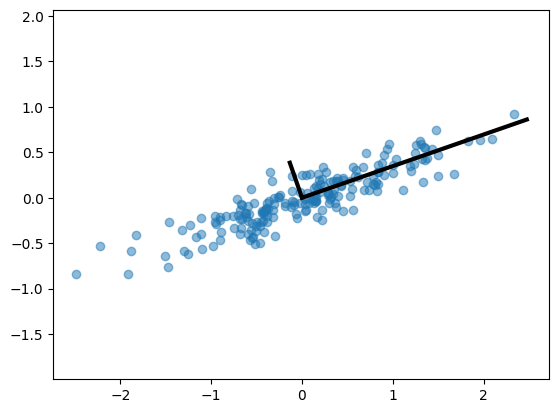

In [6]:
plt.plot(X[:, 0], X[:, 1], 'o', alpha=0.5)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    plt.plot([0, v[0]], [0, v[1]], '-k', lw=3)
plt.axis('equal');

Notice that one vector is longer than the other. In a sense, this tells us that that direction in the data is somehow more "important" than the other direction.
The explained variance quantifies this measure of "importance" in direction.

Another way to think of it is that the second principal component could be **completely ignored** without much loss of information! Let's see what our data look like if we only keep 95% of the variance:

In [7]:
clf = PCA(0.95) # keep 95% of variance
X_trans = clf.fit_transform(X)
print(X.shape)
print(X_trans.shape)

(200, 2)
(200, 1)


By specifying that we want to throw away 5% of the variance, the data is now compressed by a factor of 50%! Let's see what the data look like after this compression:

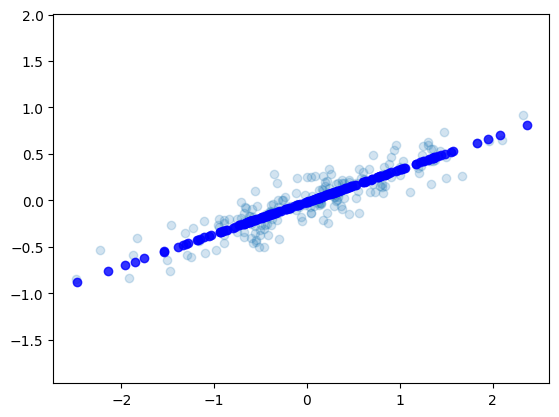

In [8]:
X_new = clf.inverse_transform(X_trans)
plt.plot(X[:, 0], X[:, 1], 'o', alpha=0.2)
plt.plot(X_new[:, 0], X_new[:, 1], 'ob', alpha=0.8)
plt.axis('equal');

The light points are the original data, while the dark points are the projected version.  We see that after truncating 5% of the variance of this dataset and then reprojecting it, the "most important" features of the data are maintained, and we've compressed the data by 50%!

This is the sense in which "dimensionality reduction" works: if you can approximate a data set in a lower dimension, you can often have an easier time visualizing it or fitting complicated models to the data.

### Application of PCA to Digits

The dimensionality reduction might seem a bit abstract in two dimensions, but the projection and dimensionality reduction can be extremely useful when visualizing high-dimensional data.  Let's take a quick look at the application of PCA to the digits data we looked at before:

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

In [ ]:
pca = PCA(2)  # project from 64 to 2 dimensions
Xproj = pca.fit_transform(X)
print(X.shape)
print(Xproj.shape)

(1797, 64)
(1797, 2)


/var/folders/bz/mr4qhtkj4zdfjg2vbhmblv_80000gp/T/ipykernel_84743/186574010.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('nipy_spectral', 10))


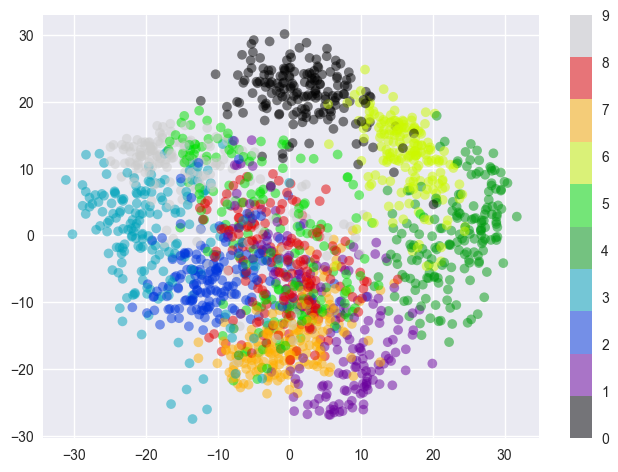

In [ ]:
plt.scatter(Xproj[:, 0], Xproj[:, 1], c=y, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar();

This gives us an idea of the relationship between the digits. Essentially, we have found the optimal stretch and rotation in 64-dimensional space that allows us to see the layout of the digits, **without reference** to the labels.

### What do the Components Mean?

PCA is a very useful dimensionality reduction algorithm, because it has a very intuitive interpretation via *eigenvectors*.
The input data is represented as a vector: in the case of the digits, our data is

$$
x = [x_1, x_2, x_3 \cdots]
$$

but what this really means is

$$
image(x) = x_1 \cdot{\rm (pixel~1)} + x_2 \cdot{\rm (pixel~2)} + x_3 \cdot{\rm (pixel~3)} \cdots
$$

If we reduce the dimensionality in the pixel space to (say) 6, we recover only a partial image:

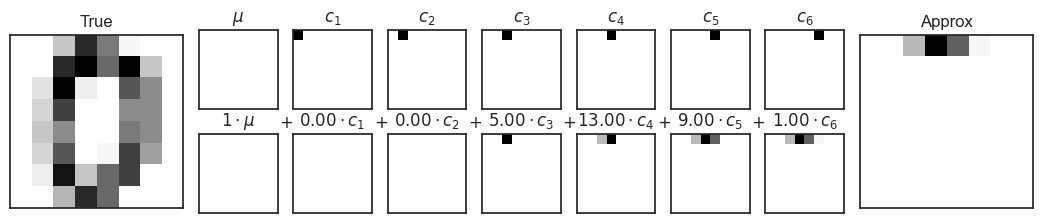

In [ ]:
from fig_code.figures import plot_image_components

with plt.style.context('seaborn-white'):
    plot_image_components(digits.data[0])

But the pixel-wise representation is not the only choice. We can also use other *basis functions*, and write something like

$$
image(x) = {\rm mean} + x_1 \cdot{\rm (basis~1)} + x_2 \cdot{\rm (basis~2)} + x_3 \cdot{\rm (basis~3)} \cdots
$$

What PCA does is to choose optimal **basis functions** so that only a few are needed to get a reasonable approximation.
The low-dimensional representation of our data is the coefficients of this series, and the approximate reconstruction is the result of the sum:

In [ ]:
from fig_code.figures import plot_pca_interactive
plot_pca_interactive(digits.data)

interactive(children=(IntSlider(value=0, description='i', max=1796), Output()), _dom_classes=('widget-interact…

Here we see that with only six PCA components, we recover a reasonable approximation of the input!

Thus, we see that PCA can be viewed from two angles. It can be viewed as **dimensionality reduction**, or it can be viewed as a form of **lossy data compression** where the loss favors noise. In this way, PCA can be used as a **filtering** process as well.

### Choosing the Number of Components

But how much information have we thrown away?  We can figure this out by looking at the **explained variance** as a function of the components:

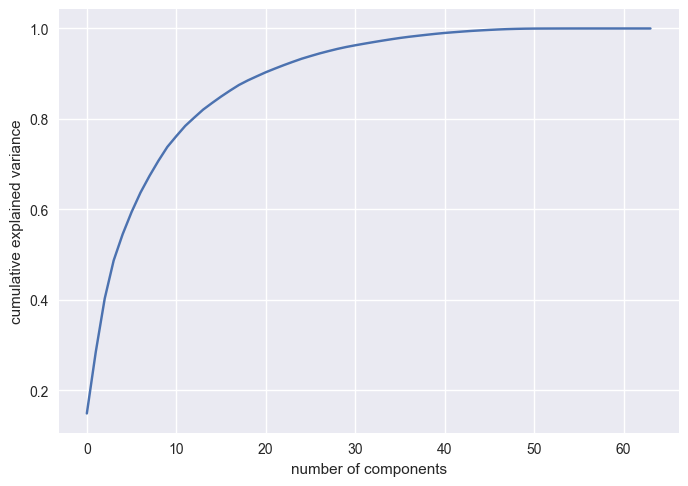

In [ ]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Here we see that our two-dimensional projection loses a lot of information (as measured by the explained variance) and that we'd need about 20 components to retain 90% of the variance.  Looking at this plot for a high-dimensional dataset can help you understand the level of redundancy present in multiple observations.

### PCA as data compression

As we mentioned, PCA can be used for is a sort of data compression. Using a small ``n_components`` allows you to represent a high dimensional point as a sum of just a few principal vectors.

Here's what a single digit looks like as you change the number of components:

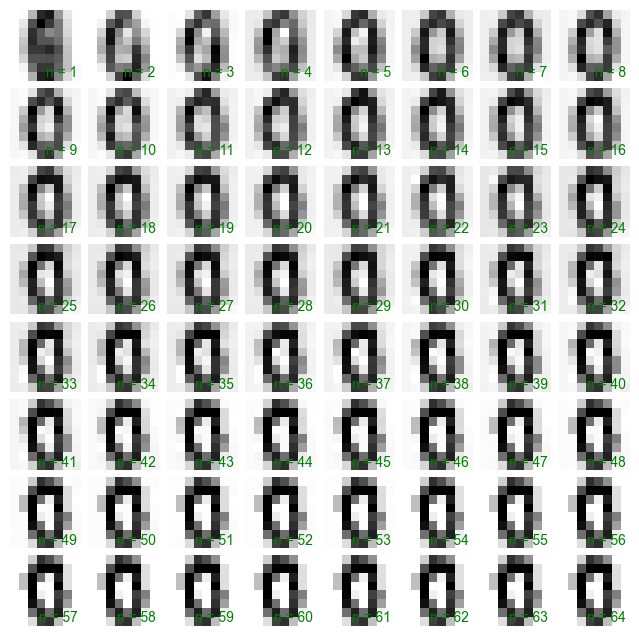

In [ ]:
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes.flat):
    pca = PCA(i + 1).fit(X)
    im = pca.inverse_transform(pca.transform(X[20:21]))

    ax.imshow(im.reshape((8, 8)), cmap='binary')
    ax.text(0.95, 0.05, 'n = {0}'.format(i + 1), ha='right',
            transform=ax.transAxes, color='green')
    ax.set_xticks([])
    ax.set_yticks([])

Let's take another look at this by using IPython's ``interact`` functionality to view the reconstruction of several images at once:

In [ ]:
from ipywidgets import interact

def plot_digits(n_components):
    fig = plt.figure(figsize=(8, 8))
    plt.subplot(1, 1, 1, frameon=False, xticks=[], yticks=[])
    nside = 10

    pca = PCA(n_components).fit(X)
    Xproj = pca.inverse_transform(pca.transform(X[:nside ** 2]))
    Xproj = np.reshape(Xproj, (nside, nside, 8, 8))
    total_var = pca.explained_variance_ratio_.sum()

    im = np.vstack([np.hstack([Xproj[i, j] for j in range(nside)])
                    for i in range(nside)])
    plt.imshow(im)
    plt.grid(False)
    plt.title("n = {0}, variance = {1:.2f}".format(n_components, total_var),
                 size=18)
    plt.clim(0, 16)

interact(plot_digits, n_components=[1, 64], nside=[1, 8]);

interactive(children=(Dropdown(description='n_components', options=(1, 64), value=1), Output()), _dom_classes=…

## Other Dimensionality Reduction Routines

Note that scikit-learn contains many other unsupervised dimensionality reduction routines: some you might wish to try are
Other dimensionality reduction techniques which are useful to know about:

- [sklearn.decomposition.PCA](http://scikit-learn.org/0.13/modules/generated/sklearn.decomposition.PCA.html):
   Principal Component Analysis
- [sklearn.decomposition.RandomizedPCA](http://scikit-learn.org/0.13/modules/generated/sklearn.decomposition.RandomizedPCA.html):
   extremely fast approximate PCA implementation based on a randomized algorithm
- [sklearn.decomposition.SparsePCA](http://scikit-learn.org/0.13/modules/generated/sklearn.decomposition.SparsePCA.html):
   PCA variant including L1 penalty for sparsity
- [sklearn.decomposition.FastICA](http://scikit-learn.org/0.13/modules/generated/sklearn.decomposition.FastICA.html):
   Independent Component Analysis
- [sklearn.decomposition.NMF](http://scikit-learn.org/0.13/modules/generated/sklearn.decomposition.NMF.html):
   non-negative matrix factorization
- [sklearn.manifold.LocallyLinearEmbedding](http://scikit-learn.org/0.13/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html):
   nonlinear manifold learning technique based on local neighborhood geometry
- [sklearn.manifold.IsoMap](http://scikit-learn.org/0.13/modules/generated/sklearn.manifold.Isomap.html):
   nonlinear manifold learning technique based on a sparse graph algorithm
   
Each of these has its own strengths & weaknesses, and areas of application. You can read about them on the [scikit-learn website](http://sklearn.org).



---





---





---



<small><i>This notebook was put together by [Jake Vanderplas](http://www.vanderplas.com). Source and license info is on [GitHub](https://github.com/jakevdp/sklearn_tutorial/).</i></small>

In [ ]:
! git clone https://github.com/data-psl/lectures2022
import sys
sys.path.append('lectures2022/notebooks/02_sklearn')
%cd 'lectures2022/notebooks/02_sklearn'

# Clustering: K-Means In-Depth

Here we'll explore **K Means Clustering**, which is an unsupervised clustering technique.

We'll start with our standard set of initial imports

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('seaborn')

## Introducing K-Means

K Means is an algorithm for **unsupervised clustering**: that is, finding clusters in data based on the data attributes alone (not the labels).

K Means is a relatively easy-to-understand algorithm.  It searches for cluster centers which are the mean of the points within them, such that every point is closest to the cluster center it is assigned to.

Let's look at how KMeans operates on the simple clusters we looked at previously. To emphasize that this is unsupervised, we'll not plot the colors of the clusters:

In [ ]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], s=50);

By eye, it is relatively easy to pick out the four clusters. If you were to perform an exhaustive search for the different segmentations of the data, however, the search space would be exponential in the number of points. Fortunately, there is a well-known *Expectation Maximization (EM)* procedure which scikit-learn implements, so that KMeans can be solved relatively quickly.

In [ ]:
from sklearn.cluster import KMeans
est = KMeans(4)  # 4 clusters
est.fit(X)
y_kmeans = est.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='rainbow');

The algorithm identifies the four clusters of points in a manner very similar to what we would do by eye!

## The K-Means Algorithm: Expectation Maximization

K-Means is an example of an algorithm which uses an *Expectation-Maximization* approach to arrive at the solution.
*Expectation-Maximization* is a two-step approach which works as follows:

1. Guess some cluster centers
2. Repeat until converged
   A. Assign points to the nearest cluster center
   B. Set the cluster centers to the mean
   
Let's quickly visualize this process:

In [ ]:
from fig_code import plot_kmeans_interactive
plot_kmeans_interactive();

This algorithm will (often) converge to the optimal cluster centers.

### KMeans Caveats

The convergence of this algorithm is not guaranteed; for that reason, scikit-learn by default uses a large number of random initializations and finds the best results.

Also, the number of clusters must be set beforehand... there are other clustering algorithms for which this requirement may be lifted.

## Application of KMeans to Digits

For a closer-to-real-world example, let's again take a look at the digits data. Here we'll use KMeans to automatically cluster the data in 64 dimensions, and then look at the cluster centers to see what the algorithm has found.

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()

In [ ]:
est = KMeans(n_clusters=10)
clusters = est.fit_predict(digits.data)
est.cluster_centers_.shape

We see ten clusters in 64 dimensions. Let's visualize each of these cluster centers to see what they represent:

In [ ]:
fig = plt.figure(figsize=(8, 3))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.imshow(est.cluster_centers_[i].reshape((8, 8)), cmap=plt.cm.binary)

We see that *even without the labels*, KMeans is able to find clusters whose means are recognizable digits (with apologies to the number 8)!

The cluster labels are permuted; let's fix this:

In [ ]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

For good measure, let's use our PCA visualization and look at the true cluster labels and K-means cluster labels:

In [ ]:
from sklearn.decomposition import PCA

X = PCA(2).fit_transform(digits.data)

kwargs = dict(cmap = plt.cm.get_cmap('rainbow', 10),
              edgecolor='none', alpha=0.6)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(X[:, 0], X[:, 1], c=labels, **kwargs)
ax[0].set_title('learned cluster labels')

ax[1].scatter(X[:, 0], X[:, 1], c=digits.target, **kwargs)
ax[1].set_title('true labels');

Just for kicks, let's see how accurate our K-Means classifier is **with no label information:**

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

80% – not bad! Let's check-out the confusion matrix for this:

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(digits.target, labels))

plt.imshow(confusion_matrix(digits.target, labels),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

Again, this is an 80% classification accuracy for an **entirely unsupervised estimator** which knew nothing about the labels.

## Example: KMeans for Color Compression

One interesting application of clustering is in color image compression. For example, imagine you have an image with millions of colors. In most images, a large number of the colors will be unused, and conversely a large number of pixels will have similar or identical colors.

Scikit-learn has a number of images that you can play with, accessed through the datasets module. For example:

In [ ]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
plt.imshow(china)
plt.grid(False);

The image itself is stored in a 3-dimensional array, of size ``(height, width, RGB)``:

In [ ]:
china.shape

We can envision this image as a cloud of points in a 3-dimensional color space. We'll rescale the colors so they lie between 0 and 1, then reshape the array to be a typical scikit-learn input:

In [ ]:
X = (china / 255.0).reshape(-1, 3)
print(X.shape)

We now have 273,280 points in 3 dimensions.

Our task is to use KMeans to compress the $256^3$ colors into a smaller number (say, 64 colors). Basically, we want to find $N_{color}$ clusters in the data, and create a new image where the true input color is replaced by the color of the closest cluster.

Here we'll use ``MiniBatchKMeans``, a more sophisticated estimator that performs better for larger datasets:

In [ ]:
from sklearn.cluster import MiniBatchKMeans

In [ ]:
# reduce the size of the image for speed
n_colors = 64

X = (china / 255.0).reshape(-1, 3)

model = MiniBatchKMeans(n_colors)
labels = model.fit_predict(X)
colors = model.cluster_centers_
new_image = colors[labels].reshape(china.shape)
new_image = (255 * new_image).astype(np.uint8)

# create and plot the new image
with plt.style.context('seaborn-white'):
    plt.figure()
    plt.imshow(china)
    plt.title('input: 16 million colors')

    plt.figure()
    plt.imshow(new_image)
    plt.title('{0} colors'.format(n_colors))

Compare the input and output image: we've reduced the $256^3$ colors to just 64.